[![Python](https://img.shields.io/badge/Python%203.11-red?logo=python&logoColor=fff)](#)
[![CUDA](https://img.shields.io/badge/CUDA_Toolkit-12.8-blue)](#)
[![cuDNN](https://img.shields.io/badge/cuDNN-9.8.0-blue)](#)
[![RFDETR](https://img.shields.io/badge/RFDETR-1.2.1-blue)](#)
[![RTMO](https://img.shields.io/badge/RTMO-0.0.14-blue)](#)

### Imports

In [21]:
import numpy as np
import glob
import torch
import os
import cv2
import matplotlib.pyplot as plt
import supervision as sv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from prettytable import PrettyTable
from rfdetr import RFDETRLarge
from tqdm import tqdm
from rtmlib import Custom
from sklearn.metrics import (
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [18]:
forms = [1, 2, 3, 4]
number_of_classes = len(forms)
HOME = os.getcwd()

### Device

In [19]:
!nvidia-smi

Fri Jan 30 20:06:40 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.44                 Driver Version: 591.44         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P8              5W /   99W |     674MiB /   8188MiB |     33%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Preprocessing

#### Detection + Tracking + Pose Extraction

In [ ]:
class KeypointExtractor:
    def __init__(
            self,
            save_keypoints: bool = False,
            movable_video: bool = False,
            save_extracted_features_clip: bool = False,
            no_norm: bool = False,
            only_translation_norm: bool = False,
            only_scale_norm: bool = False,
            both_norm: bool = False,
            resize_max_width: int = 1280,
            resize_max_height: int = 720
    ):
        """
        :param save_keypoints: If you want to save keypoints in .npz file, pass it True, the default is False.
        :param movable_video: If you want to move the clip to another path after feature extraction, pass it True, the default is False.
        :param save_extracted_features_clip:
        :param resize_max_width:
        :param resize_max_height:
        """

        norm_flags = [no_norm, only_translation_norm, only_scale_norm, both_norm]
        if sum(norm_flags) != 1:
            raise ValueError("Exactly one normalization mode must be True.")

        self.HOME = os.getcwd()
        self.device = device
        self.rfdetrModel = RFDETRLarge()
        self.pose_estimation = Custom(
            pose_class='RTMO',
            pose='https://download.openmmlab.com/mmpose/v1/projects/rtmo/onnx_sdk/rtmo-l_16xb16-600e_body7-640x640-b37118ce_20231211.zip',
            mode='performance',
            pose_input_size=(640, 640),
            backend='onnxruntime',
            device=device
        )
        self.edge_annotator = sv.EdgeAnnotator(
            color=sv.Color.GREEN,
            thickness=2
        )
        self.label_index_annotator = sv.RichLabelAnnotator(
            text_position=sv.Position.CENTER
        )
        self.box_annotator = sv.BoxAnnotator()
        self.resize_max_width = resize_max_width
        self.resize_max_height = resize_max_height
        self.save_keypoints = save_keypoints
        self.movable_video = movable_video
        self.save_extracted_features_clip = save_extracted_features_clip
        self.padding = 100
        self.no_norm = no_norm
        self.only_translation_norm = only_translation_norm
        self.only_scale_norm = only_scale_norm
        self.both_norm = both_norm

    def resize_to_fit(self, image):
        """
        Resize frames to fix size to be able to see frames on any size of screens
        :param image: The image to resize
        :return: The resized frame
        """

        h, w = image.shape[:2]
        scale_w = self.resize_max_width / w
        scale_h = self.resize_max_height / h
        scale = min(scale_w, scale_h, 1.0)  # نمی‌خواهیم بزرگ کنیم
        new_w = int(w * scale)
        new_h = int(h * scale)
        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    def move_file(self, source: str, form_number: int):
        """
        Move file to destination
        :param source: Source path
        :param form_number
        :return: ❌ nothing
        """

        try:
            destination_dir = f'{self.HOME}\\Dataset\\Export\\form{form_number}\\done'
            os.makedirs(f'{destination_dir}', exist_ok=True)

            clip_name = source.split('\\')[-1]
            if clip_name:
                os.rename(source, f'{destination_dir}\\{clip_name}')
        except Exception as e:
            print(f"An error occurred: {e}")

    def normalize_keypoints(self, kp):
        """
        Normalize keypoints according to:
         - distance between shoulder and center of hip to try to ensure that the size of a person's body (such as being a child or an adult) does not affect the model's learning and testing.
         - nose distance to try to ensure that camera movement does not affect the model's learning and testing.

        :param kp: list of keypoints
        :return: Tow parameter: If there is no problem the 1st return is True and the second is the normalized flatten keypoints
        """

        kp = kp.copy()

        # محاسبه مراکز
        shoulder_center = (kp[5] + kp[6]) / 2
        hip_center = (kp[11] + kp[12]) / 2
        torso_length = np.linalg.norm(shoulder_center - hip_center)

        if torso_length == 0:
            return False, None

        # -----------------------------
        # No normalization
        # -----------------------------
        if self.no_norm:
            return True, kp.flatten()

        # -----------------------------
        # Only Translation Normalization
        # -----------------------------
        if self.only_translation_norm:
            kp = kp - kp[0]  # بینی به (0,0)
            return True, kp.flatten()

        # -----------------------------
        # Only Scale Normalization
        # -----------------------------
        if self.only_scale_norm:
            kp = kp / torso_length
            return True, kp.flatten()

        # -----------------------------
        # Both (Translation + Scale)
        # -----------------------------
        if self.both_norm:
            kp = (kp - kp[0]) / torso_length
            return True, kp.flatten()

        return False, None

    def sort_detections(self, detections):
        # گرفتن ایندکس‌های مرتب‌شده بر اساس tracker_id
        sorted_indices = np.argsort(detections.tracker_id)

        # مرتب‌سازی تمام ویژگی‌ها طبق این ایندکس‌ها
        detections.xyxy = detections.xyxy[sorted_indices]
        detections.confidence = detections.confidence[sorted_indices]
        detections.class_id = detections.class_id[sorted_indices]
        detections.tracker_id = detections.tracker_id[sorted_indices]
        return detections

    def save_func(self, sinc, frame):
        sinc.write_frame(frame=frame)

    def process_video(self, clip: str, form_number: int):
        """
        :param clip:
        :param form_number:
        :return: Keypoints of person in video
        """

        if self.no_norm:
            norm_type = "no_norm"
        elif self.only_translation_norm:
            norm_type = "translation"
        elif self.only_scale_norm:
            norm_type = "scale"
        elif self.both_norm:
            norm_type = "both"

        cap = cv2.VideoCapture(clip)
        video_name = clip.split("\\")[-1]

        destination_dir = f'{self.HOME}\\dataset\\form{form_number}\\output_{norm_type}'
        os.makedirs(destination_dir, exist_ok=True)

        tracker = sv.ByteTrack()

        if not cap.isOpened():
            print(f"Error opening video file: {clip}")
            return None

        video_info = sv.VideoInfo.from_video_path(video_path=clip)
        video_sink = sv.VideoSink(target_path=f'{destination_dir}\\{video_name}', video_info=video_info)
        frame_generator = sv.get_video_frames_generator(source_path=clip, stride=4)

        first_frame_processed = False
        selected_tracker_id = 0
        sequence = []
        label = []

        with video_sink as sinc:
            with tqdm(frame_generator, total=video_info.total_frames) as t_loader:
                for frame in t_loader:
                    img_show = frame.copy()
                    h, w = img_show.shape[:2]
                    detections = self.rfdetrModel.predict(images=img_show)
                    detections = detections[detections.class_id == 1]
                    if not len(detections.xyxy) > 0:
                        self.save_func(sinc=sinc, frame=frame)
                        continue

                    detections = tracker.update_with_detections(detections=detections)
                    detections = self.sort_detections(detections=detections)

                    if detections.tracker_id is not None:
                        labels = [str(id_) for id_ in detections.tracker_id]
                    else:
                        labels = ["" for _ in range(len(detections.xyxy))]

                    annotated_frame = self.label_index_annotator.annotate(
                        scene=img_show,
                        detections=detections,
                        labels=labels,
                    )

                    if not first_frame_processed:
                        if not np.isin(detections.tracker_id, -1).any():
                            # cv2.imshow('Select Tracker ID', annotated_frame)
                            # cv2.waitKey(1)
                            # selected_tracker_id = int(input("Enter tracker ID to keep: "))
                            selected_tracker_id = 1
                            first_frame_processed = True
                            # cv2.destroyWindow('Select Tracker ID')
                        else:
                            # print('Has some -1')
                            self.save_func(sinc=sinc, frame=frame)
                            continue

                    index = np.where(detections.tracker_id == selected_tracker_id)[0]
                    if len(index) < 1:
                        # print("No detection found")
                        self.save_func(sinc=sinc, frame=frame)
                        continue
                    index = index[0]

                    x1, y1, x2, y2 = map(int, detections.xyxy[index])
                    x1 = max(x1 - self.padding, 0)
                    y1 = max(y1 - self.padding, 0)
                    x2 = min(x2 + self.padding, w)
                    y2 = min(y2 + self.padding, h)
                    cropped = img_show[y1:y2, x1:x2]

                    keypoints, scores = self.pose_estimation(cropped)

                    if np.all(keypoints[0] == 0):
                        # print("all keypoints are 0")
                        self.save_func(sinc=sinc, frame=frame)
                        continue

                    normalized_status, normalized_keypoints = self.normalize_keypoints(keypoints[0])
                    if not normalized_status:
                        # print("Cannot Normalize")
                        self.save_func(sinc=sinc, frame=frame)
                        continue

                    sequence.append(normalized_keypoints)

                    if self.save_keypoints:
                        label.append(form_number)

                    for kp in keypoints[0]:
                        kp[0] += x1
                        kp[1] += y1

                    kpts = sv.KeyPoints(
                        xy=np.array([keypoints[0]]),
                        confidence=np.array([scores[0]])
                    )

                    annotated_frame = self.edge_annotator.annotate(
                        scene=annotated_frame,
                        key_points=kpts
                    )

                    if self.save_extracted_features_clip:
                        self.save_func(sinc=sinc, frame=annotated_frame)

                    t_loader.set_description(f"Name: {video_name} - {norm_type}")
                    t_loader.set_postfix(keypoints=len(sequence))

                    annotated_frame = self.resize_to_fit(image=annotated_frame)
                    cv2.imshow(video_name, annotated_frame)
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break

        cap.release()
        cv2.destroyAllWindows()

        if self.save_keypoints:
            keypoints_dir = f"{self.HOME}\\dataset\\form{form_number}\\keypoints_{norm_type}"
            os.makedirs(name=f'{keypoints_dir}', exist_ok=True)

            with open(f'{keypoints_dir}\\example.txt', 'a') as file:
                file.write(f"{video_name}: {len(sequence)}\n")

            np.savez(file=f"{keypoints_dir}\\{video_name.split('.')[0]}_id{selected_tracker_id}_keypoints.npz",
                     X=sequence, y=label)

        return sequence

    def give_clips(self, form_number: int):
        """
        Get clips paths
        :param form_number:
        :return: return clips paths
        """
        clip_dir = f'{HOME}\\dataset\\form{form_number}\\clips'
        clips = []
        for file in glob.glob(f'{clip_dir}\\*.mp4'):
            clips.append(file)
        return clips

    def process_all_videos(self):
        """
        :return: ❌ nothing
        """
        for form_number in forms:
            clips = self.give_clips(form_number=form_number)
            for clip in clips:
                try:
                    self.process_video(clip=clip, form_number=form_number)

                    if self.movable_video:
                        self.move_file(source=clip, form_number=form_number)
                except Exception as e:
                    print(f"An error occurred: {e}")

In [ ]:
keypoint_extractor = KeypointExtractor(save_keypoints=True, movable_video=False, save_extracted_features_clip=True, no_norm=True)

In [ ]:
keypoint_extractor.process_all_videos()

#### Extract from existing keypoint extracted (no normalization)

In [ ]:
def normalize_sequence(sequence, mode="translation"):
    """
    sequence: numpy array shape (T, 34)
    mode: translation | scale | both
    """
    normalized_seq = []

    for frame in sequence:
        kp = frame.reshape(-1, 2)  # (17,2)

        shoulder_center = (kp[5] + kp[6]) / 2
        hip_center = (kp[11] + kp[12]) / 2
        torso_length = np.linalg.norm(shoulder_center - hip_center)

        if torso_length == 0:
            continue

        if mode == "translation":
            new_kp = kp - kp[0]

        elif mode == "scale":
            new_kp = kp / torso_length

        else:
            raise ValueError("Invalid mode")

        normalized_seq.append(new_kp.flatten())

    return np.array(normalized_seq)


def process_form(form_number):
    print(f"\nProcessing form {form_number}")

    input_dir = f"{HOME}\\Dataset\\Export\\form{form_number}\\keypoints_no_norm"

    translation_dir = f"{HOME}\\Dataset\\Export\\form{form_number}\\keypoints_translation"
    scale_dir = f"{HOME}\\Dataset\\Export\\form{form_number}\\keypoints_scale"

    os.makedirs(translation_dir, exist_ok=True)
    os.makedirs(scale_dir, exist_ok=True)

    files = glob.glob(f"{input_dir}\\*.npz")

    for file_path in tqdm(files):

        data = np.load(file_path, allow_pickle=True)
        X = data["X"]   # shape (T, 34)
        y = data["y"]

        X = np.array(X)

        # --- Translation ---
        X_translation = normalize_sequence(X, mode="translation")

        # --- Scale ---
        X_scale = normalize_sequence(X, mode="scale")

        file_name = os.path.basename(file_path)

        np.savez(
            f"{translation_dir}\\{file_name}",
            X=X_translation,
            y=y
        )

        np.savez(
            f"{scale_dir}\\{file_name}",
            X=X_scale,
            y=y
        )

for form in forms:
    process_form(form)

### Processing

In [ ]:
norm_types = {
    "No norm": "_no_norm",
    "Scale": "_scale",
    "Translation": "_translation",
    "Both norm": "_both"
}

def extract_base_feature(seq):
    return np.mean(seq, axis=0)

results = {}

for norm_name, norm_suffix in norm_types.items():
    results[norm_name] = {
        "logreg": {
            "acc": [], "prec": [], "rec": [], "f1": [],
            "y_true": [], "y_pred": []
        },
        "svm": {
            "acc": [], "prec": [], "rec": [], "f1": [],
            "y_true": [], "y_pred": []
        },
    }

    files = []
    for form_number in forms:
        files += glob.glob(
            f"{HOME}/dataset/form{form_number}/keypoints{norm_suffix}/*_keypoints.npz"
        )

    X_all, y_all = [], []

    for file in files:
        data = np.load(file, allow_pickle=True)
        seq = np.array(data["X"])
        label = int(data["y"][0])

        X_all.append(np.mean(seq, axis=0))  # Base
        y_all.append(label)

    X_all = np.array(X_all)
    y_all = np.array(y_all)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X_all, y_all):
        X_train, X_test = X_all[train_idx], X_all[test_idx]
        y_train, y_test = y_all[train_idx], y_all[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Logistic Regression
        lr = LogisticRegression(max_iter=5000)
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)

        results[norm_name]["logreg"]["acc"].append(accuracy_score(y_test, y_pred))
        results[norm_name]["logreg"]["prec"].append(precision_score(y_test, y_pred, average="macro"))
        results[norm_name]["logreg"]["rec"].append(recall_score(y_test, y_pred, average="macro"))
        results[norm_name]["logreg"]["f1"].append(f1_score(y_test, y_pred, average="macro"))
        results[norm_name]["logreg"]["y_true"].extend(y_test)
        results[norm_name]["logreg"]["y_pred"].extend(y_pred)

        # SVM
        svm = SVC(kernel="rbf")
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        results[norm_name]["svm"]["acc"].append(accuracy_score(y_test, y_pred))
        results[norm_name]["svm"]["prec"].append(precision_score(y_test, y_pred, average="macro"))
        results[norm_name]["svm"]["rec"].append(recall_score(y_test, y_pred, average="macro"))
        results[norm_name]["svm"]["f1"].append(f1_score(y_test, y_pred, average="macro"))

        results[norm_name]["svm"]["y_true"].extend(y_test)
        results[norm_name]["svm"]["y_pred"].extend(y_pred)

#### 7 Metrics

In [9]:
table = PrettyTable()
table.field_names = [
    "Normalization",
    "Model",
    "Accuracy",
    "Precision",
    "Recall",
    "F1-score"
]

for norm_name, models in results.items():
    for model_name, metrics in models.items():
        def mean_std(x):
            return f"{np.mean(x):.4f} ± {np.std(x):.4f}"

        table.add_row([
            norm_name,
            model_name.upper(),
            mean_std(metrics["acc"]),
            mean_std(metrics["prec"]),
            mean_std(metrics["rec"]),
            mean_std(metrics["f1"]),
        ])

print(table)

+---------------+--------+-----------------+-----------------+-----------------+-----------------+
| Normalization | Model  |     Accuracy    |    Precision    |      Recall     |     F1-score    |
+---------------+--------+-----------------+-----------------+-----------------+-----------------+
|    No norm    | LOGREG | 0.9426 ± 0.0108 | 0.9438 ± 0.0095 | 0.9424 ± 0.0107 | 0.9421 ± 0.0110 |
|    No norm    |  SVM   | 0.6444 ± 0.0485 | 0.6739 ± 0.0418 | 0.6437 ± 0.0485 | 0.6316 ± 0.0571 |
|     Scale     | LOGREG | 0.9426 ± 0.0148 | 0.9435 ± 0.0141 | 0.9425 ± 0.0149 | 0.9422 ± 0.0149 |
|     Scale     |  SVM   | 0.6370 ± 0.0451 | 0.6476 ± 0.0535 | 0.6367 ± 0.0451 | 0.6326 ± 0.0475 |
|  Translation  | LOGREG | 0.9722 ± 0.0293 | 0.9738 ± 0.0263 | 0.9722 ± 0.0293 | 0.9721 ± 0.0293 |
|  Translation  |  SVM   | 0.9074 ± 0.0227 | 0.9110 ± 0.0216 | 0.9071 ± 0.0225 | 0.9063 ± 0.0228 |
|   Both norm   | LOGREG | 0.9722 ± 0.0185 | 0.9739 ± 0.0164 | 0.9722 ± 0.0186 | 0.9722 ± 0.0185 |
|   Both n

#### Bar chart

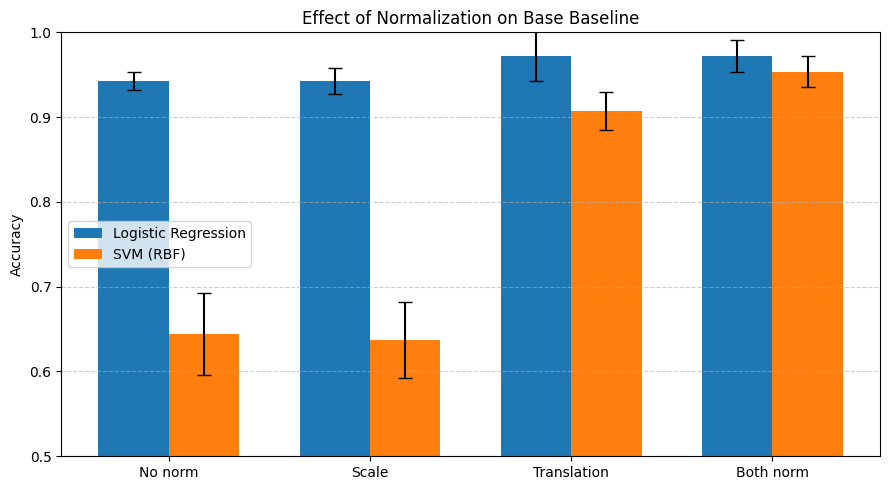

In [12]:
norms = list(norm_types.keys())

lr_mean = [np.mean(results[n]["logreg"]["acc"]) for n in norms]
lr_std  = [np.std(results[n]["logreg"]["acc"])  for n in norms]

svm_mean = [np.mean(results[n]["svm"]["acc"]) for n in norms]
svm_std  = [np.std(results[n]["svm"]["acc"])  for n in norms]

x = np.arange(len(norms))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, lr_mean, width, yerr=lr_std, capsize=5, label="Logistic Regression")
plt.bar(x + width/2, svm_mean, width, yerr=svm_std, capsize=5, label="SVM (RBF)")

plt.xticks(x, norms)
plt.ylabel("Accuracy")
plt.title("Effect of Normalization on Base Baseline")
plt.ylim(0.5, 1.0)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()

save_dir = f"{HOME}/baseline/bar_chart"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(f"{save_dir}/bar_chart.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.savefig(f"{save_dir}/bar_chart.png", format="png", dpi=500)
plt.savefig(f"{save_dir}/bar_chart.tiff", format="tiff", dpi=500)
plt.show()

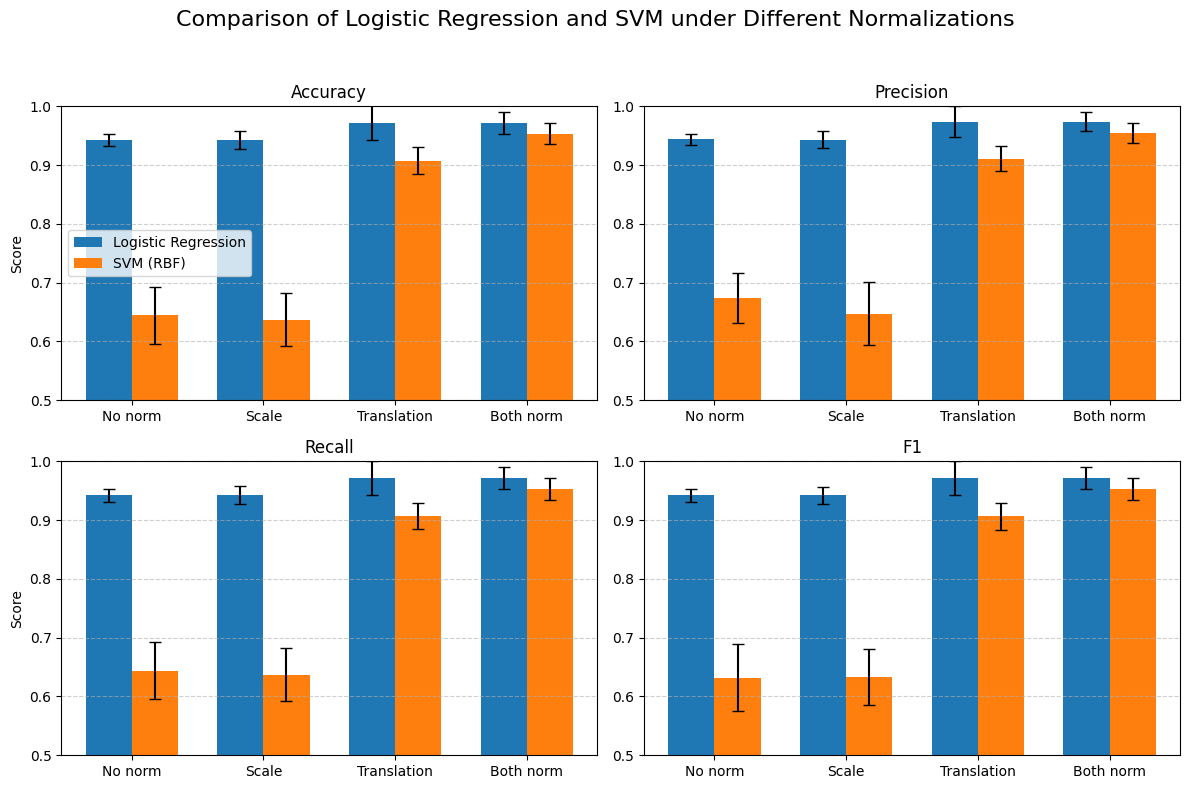

In [13]:
norms = list(norm_types.keys())

metrics = ["acc", "prec", "rec", "f1"]
metric_labels = ["Accuracy", "Precision", "Recall", "F1"]

lr_means = {m: [np.mean(results[n]["logreg"][m]) for n in norms] for m in metrics}
lr_stds = {m: [np.std(results[n]["logreg"][m]) for n in norms] for m in metrics}

svm_means = {m: [np.mean(results[n]["svm"][m]) for n in norms] for m in metrics}
svm_stds = {m: [np.std(results[n]["svm"][m]) for n in norms] for m in metrics}

x = np.arange(len(norms))
width = 0.35

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, m in enumerate(metrics):
    ax = axs[i]
    ax.bar(x - width/2, lr_means[m], width, yerr=lr_stds[m], capsize=4, label="Logistic Regression")
    ax.bar(x + width/2, svm_means[m], width, yerr=svm_stds[m], capsize=4, label="SVM (RBF)")
    ax.set_title(metric_labels[i])
    ax.set_xticks(x)
    ax.set_xticklabels(norms)
    ax.set_ylim(0.5, 1.0)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    if i % 2 == 0:
        ax.set_ylabel("Score")
    if i == 0:
        ax.legend()

plt.suptitle("Comparison of Logistic Regression and SVM under Different Normalizations", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

save_dir = f"{HOME}/baseline/bar_chart_4_metrics"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(f"{save_dir}/image.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.savefig(f"{save_dir}/image.png", format="png", dpi=500)
plt.savefig(f"{save_dir}/image.tiff", format="tiff", dpi=500)
plt.show()

#### Confusion Matrix

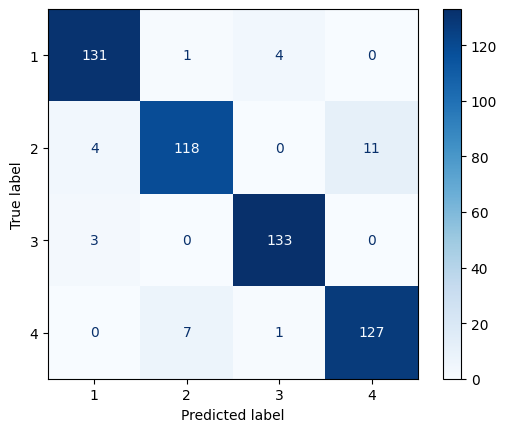

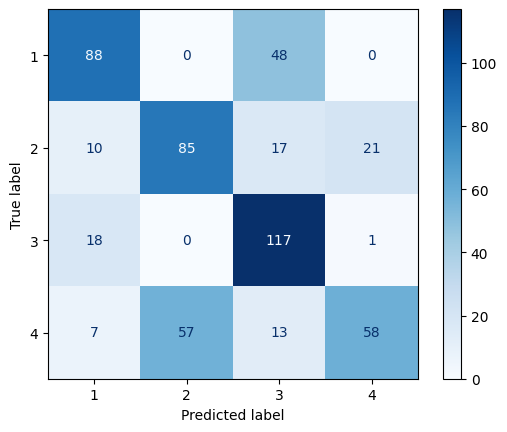

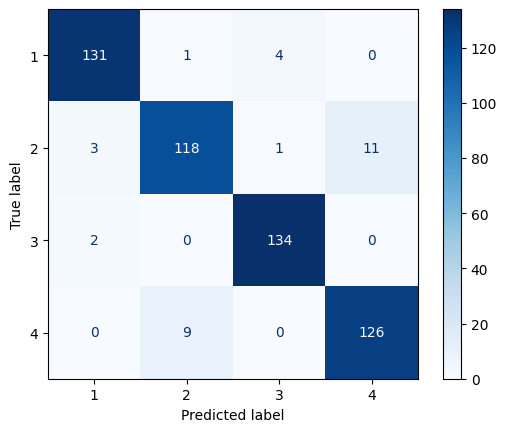

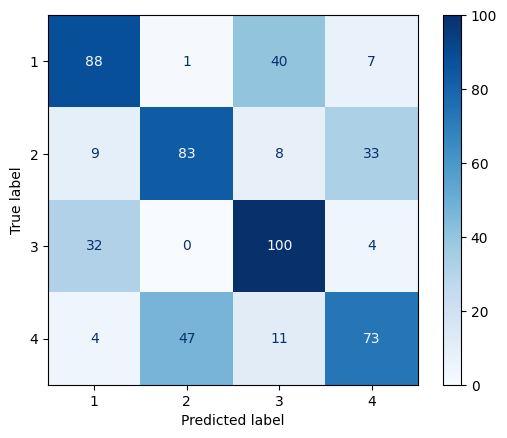

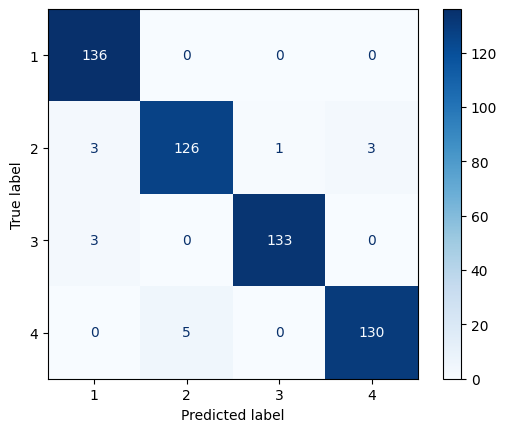

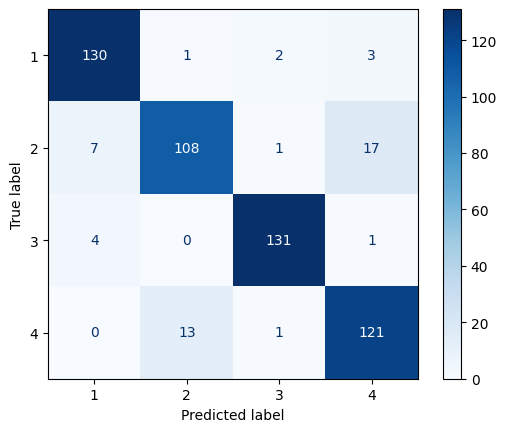

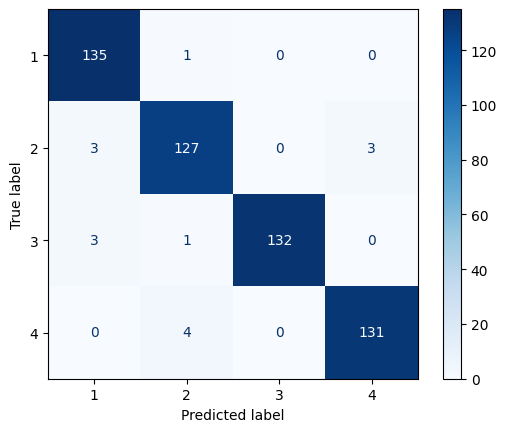

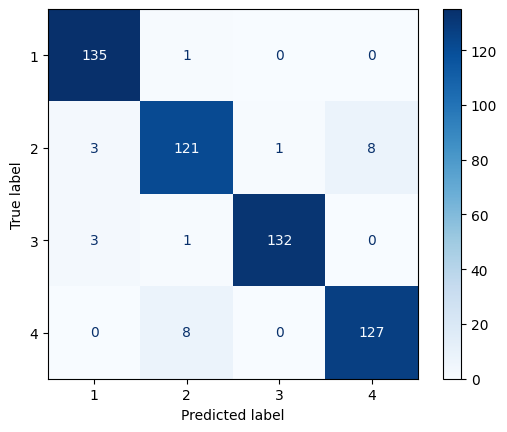

In [16]:
save_dir = f"{HOME}/baseline/cm/"
os.makedirs(save_dir, exist_ok=True)

for norm_name, models in results.items():
    for model_name, metrics in models.items():
        cm = confusion_matrix(
            metrics["y_true"],
            metrics["y_pred"]
        )

        disp = ConfusionMatrixDisplay.from_predictions(metrics["y_true"], metrics["y_pred"], cmap='Blues')

        plt.savefig(f"{save_dir}/cm_{norm_name}_{model_name.upper()}.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
        plt.savefig(f"{save_dir}/cm_{norm_name}_{model_name.upper()}.png", format="png", dpi=500)
        plt.savefig(f"{save_dir}/cm_{norm_name}_{model_name.upper()}.tiff", format="tiff", dpi=500)

        with open(f"{save_dir}/all.txt", "a") as f:
            f.write(f"\nConfusion Matrix | {norm_name} | {model_name.upper()}\n{cm}\n")